<a href="https://colab.research.google.com/github/Tieck-IT/GAN_paper_study/blob/main/WGAN/wgan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan/wgan.py

In [ ]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [ ]:
os.makedirs("images", exist_ok=True)

In [ ]:
class opt:
    n_epochs = 200
    batch_size = 64
    lr = 0.00005
    n_cpu = 8
    latent_dim = 100
    img_size = 28
    channels = 1
    n_critic = 5
    clip_value = 0.01
    sample_interval = 400

In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
# parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
# parser.add_argument("--lr", type=float, default=0.00005, help="learning rate")
# parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
# parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
# parser.add_argument("--channels", type=int, default=1, help="number of image channels")
# parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
# parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
# parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
# opt = parser.parse_args()
# print(opt)

In [ ]:
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


generator, discriminator 선언

In [ ]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Dataset(MNIST) & DataLoader

In [ ]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)


# Optimizer
- RMSprop

   https://onevision.tistory.com/entry/Optimizer-%EC%9D%98-%EC%A2%85%EB%A5%98%EC%99%80-%ED%8A%B9%EC%84%B1-Momentum-RMSProp-Adam

- 실험 결과 critic을 학습 할 때 Adam과 같은 mometum 베이스 optimizer를 사용하면 학습이 unstable 하다 (paper 4절)

 

이유는, loss값이 튀고 샘플이 좋지 않은 경우(일반적으로 학습 초반) Adam이 가고자 하는 방향, 즉 이전에 기억했던 방향(Adam step)과 gradient의 방향 간의 cosine값이 음수가 된다는 것이다. 일반적으로 nonstationary 문제(극한값이 존재하지 않음)에 대해서는 momentum계열보다 RMSProp이 성능이 더 좋다고 한다.(여기서 정의한 문제도 nonstationary problem)

In [ ]:
# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

# Training

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
D_loss_list = []
G_loss_list = []
# ----------
#  Training
# ----------

batches_done = 0
for epoch in range(opt.n_epochs):

    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)

        # Train the generator every n_critic iterations
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )
            D_loss_list += [loss_D.item()*(-1)]
            G_loss_list += [loss_G.item()*(-1)]

        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            last_img_num = batches_done
        batches_done += 1

Streaming output truncated to the last 5000 lines.
[Epoch 173/200] [Batch 380/938] [D loss: -0.072824] [G loss: -3.150096]
[Epoch 173/200] [Batch 385/938] [D loss: -0.059969] [G loss: -3.144238]
[Epoch 173/200] [Batch 390/938] [D loss: -0.075242] [G loss: -3.225222]
[Epoch 173/200] [Batch 395/938] [D loss: -0.104259] [G loss: -3.094466]
[Epoch 173/200] [Batch 400/938] [D loss: -0.077095] [G loss: -3.194988]
[Epoch 173/200] [Batch 405/938] [D loss: -0.112236] [G loss: -3.099587]
[Epoch 173/200] [Batch 410/938] [D loss: -0.092954] [G loss: -3.160302]
[Epoch 173/200] [Batch 415/938] [D loss: -0.104530] [G loss: -3.034672]
[Epoch 173/200] [Batch 420/938] [D loss: -0.122328] [G loss: -2.921412]
[Epoch 173/200] [Batch 425/938] [D loss: -0.078289] [G loss: -3.093543]
[Epoch 173/200] [Batch 430/938] [D loss: -0.078536] [G loss: -3.167063]
[Epoch 173/200] [Batch 435/938] [D loss: -0.092972] [G loss: -3.105530]
[Epoch 173/200] [Batch 440/938] [D loss: -0.095786] [G loss: -3.080959]
[Epoch 173/20

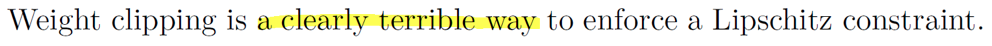

- Lipschitz조건을 만족시키기 위해 gradient를 강제로 clipping
    - 학습 속도가 느려짐
    - 후에 WGAN-GP (Gradient Penalty)에서 개선됨
- Lipschitz조건이란, 두 점 사이의 거리를 일정 비 이상으로 증가시키지 않는 함수

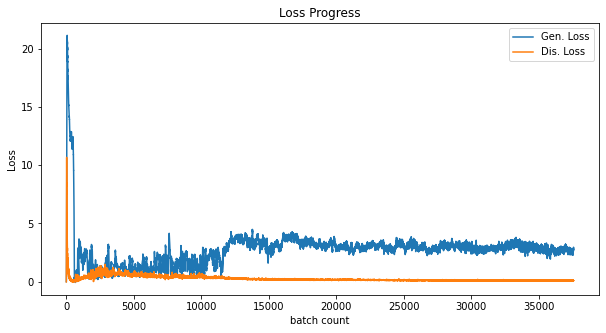

In [ ]:
# plot loss history

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(G_loss_list, label='Gen. Loss')
plt.plot(D_loss_list, label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

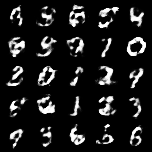

In [ ]:
%matplotlib inline
from IPython.display import Image
Image(f"images/{last_img_num}.png")